In [1]:
# from BMI_HBVmountain_Python import *
# from Calibration import *
import os
import netCDF4 as nc

import cma
import hashlib
import time
import warnings
from pathlib import Path
# from cartopy.io import shapereader
from cftime import date2num
from matplotlib.ticker import MaxNLocator
import logging
logging.basicConfig(level=logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)
from cma.fitness_transformations import EvalParallel2
import matplotlib as plt

# import fiona
# from cartopy.io import shapereader
from ruamel.yaml import YAML
# import ewatercycle.models
# from ewatercycle.config import CFG
# from ewatercycle.forcing import load_foreign
# from ewatercycle.observation.grdc import get_grdc_data
# from ewatercycle.util import get_time

In [ ]:
POPSIZE = 9  # it can be equal to number of available cores * 0.75
MAXITER = 50

 ### Load forcing data

In [6]:
forcing = pd.read_csv('Data/ThunderCreek/forcing_thundercreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['time'][i] = forcing['time'][i].date()
forcing.set_index('time', inplace=True)
forcing

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,streamflow,temp_era5,prec_era5
time,,,
1986-01-01,0.962825,-4.225952,18.505061
1986-01-02,0.971722,-4.649109,4.130639
1986-01-03,0.953927,-4.009430,5.363479
1986-01-04,0.944712,-5.197113,0.000000
1986-01-05,0.944712,-3.785156,10.307294
...,...,...,...
2005-12-27,6.451560,-0.104980,16.528907
2005-12-28,5.173832,-1.296906,18.620241
2005-12-29,4.535126,-3.694000,4.846727


### Functions

In [2]:
def run_model_cma(parameters):
    """Setup and run model."""
    model = BMI_HBVmountain()
    

    # Generate a random tag for work_dir name
    # Each work_dir is used by one worker in multiprocessing
#    tag = hashlib.md5(str(parameters).encode('utf-8')).hexdigest()
#    work_dir = CFG['output_dir'] / f"marrmot-m14_{tag}"
#     print(parameters)
#     parameters = parameters[0]
    if len(parameters) ==5:
        cfg_file = model.setup(bare_parameters=  Parameters(parameters[0][0], parameters[0][1], parameters[0][2], parameters[0][3], parameters[0][4],
                                                                     parameters[0][5], parameters[0][6], parameters[0][7], parameters[0][8], parameters[0][9]),
                                        forest_parameters=Parameters(parameters[1][0], parameters[1][1], parameters[1][2], parameters[1][3], parameters[1][4],
                                                                     parameters[1][5], parameters[1][6], parameters[1][7], parameters[1][8], parameters[1][9]), 
                                        grass_parameters= Parameters(parameters[2][0], parameters[2][1], parameters[2][2], parameters[2][3], parameters[2][4],
                                                                     parameters[2][5], parameters[2][6], parameters[2][7], parameters[2][8], parameters[2][9]),
                                        rip_parameters=   Parameters(parameters[3][0], parameters[3][1], parameters[3][2], parameters[3][3], parameters[3][4],
                                                                     parameters[3][5], parameters[3][6], parameters[3][7], parameters[3][8], parameters[3][9]), 
                                        slow_parameters=  Slow_Paramters(parameters[4][0], parameters[4][1])
        )
    else:
        cfg_file = model.setup(bare_parameters=  Parameters(parameters[8], parameters[6], 0, parameters[0], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[7], parameters[0]),
                                        forest_parameters=Parameters(parameters[11], parameters[6], 0, parameters[9], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[10], parameters[0]),
                                        grass_parameters= Parameters(parameters[14], parameters[6], 0, parameters[12], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[13], parameters[0]),
                                        rip_parameters=   Parameters(parameters[17], parameters[6], 0, parameters[15], parameters[18],
                                                                     parameters[1], parameters[2], parameters[3], parameters[16], parameters[0]),
                                        slow_parameters=  Slow_Paramters(parameters[5], parameters[19]))        
    
    # Initialize the model inside the docker container through GRPC4bmi
    model.initialize(cfg_file)
    
    model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
    model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))
    model.set_value('Date', list(forcing.index.values))
    model.set_value('Current_Date', forcing.index.values[0])  
    
    model.set_value('Elevation', Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands
    model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
    model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
    model.set_value('bare_input', HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('forest_input', HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('grass_input', HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('rip_input', HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('Total_Elevationbands', 4)
    model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
    model.set_value('bare_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('forest_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('grass_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('rip_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
  

    simulated_discharge = []
    timestamp = []
    # Perform all timesteps of the model, update output fields
    while (model.get_current_time() < (model.get_value_ptr('Date'))[1000]):  
        model.update()
        # Store model time and variable output after the spin up period
        simulated_discharge.append(model.get_value_ptr('Discharge'))
        timestamp.append(model.get_value_ptr('Current_Date'))
        
    simulated_discharge_df = pd.DataFrame(
        {'streamflow': simulated_discharge},
        index=pd.to_datetime(timestamp)
    )
    precipitation = forcing.prec_era5
    model.finalize()
    return simulated_discharge_df.streamflow, precipitation



def objective_function(parameters, Qobserved, area):
    """Calculate objective function.

    Runs the model, converts the output to GRDC streamflow units
    and calculates NSE from simulation data with observation data.
    This is the function that is going to be optimized by scipy.brute.
    """
    Qmodelled = run_model_cma(parameters)
    QobservedAverage = np.ones(len(Qobserved)) * np.mean(Qobserved)
    Nominator = np.sum((Qmodelled - Qobserved)**2)
    Denominator = np.sum((Qobserved - QobservedAverage)**2)
    NashSutcliffe = 1 - (Nominator / Denominator)
    return 1 - NashSutcliffe


def transform(scaled_parameters):
    """Transforms the scaled_parameter to parameter.

    if x = scaled_parameter and y = parameter,
    then x is in the range [0, 10] and y is in the range [a, b].
    To map the values [0, 10] into [a, b],
    we use the transformations a + (b-a) * x/10.
    For more information on this transformation,
    please see
    http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
    """
    PARAMETERS_BOUNDS = [[0, 2.0],
                 [1.0, 5.0],
                 [0.001, 1.0],
                 [0.1, 0.9],
                 [0.1, 3.0],
                 [0.001, 0.1],
                 [0.4, 0.8],
                 [1.0, 75.0],
                 [0.1, 2.0],
                 [1.0, 10.0],
                 [50.0, 750.0],
                 [0.1, 2.0],
                 [0.1, 5.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 8.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 3.0],
                 [0.05, 0.5]]
    parameters = []
    for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
        scale = (bound[1] - bound[0]) / 10.0
        parameter = bound[0] + (scale * scaled_parameter)
        parameters.append(parameter)
    return parameters


def wrapped_objective_function(scaled_parameters, observation):
    """A wrapper around the objective function.

    The wrapper transforms the scaled_parameters before
    the actual function call.
    """
    parameters = transform(scaled_parameters)
    Qmodelled, precipitation = run_model_cma(parameters)
    precipitation.index, Qmodelled.index, observation.index = pd.to_datetime(precipitation.index), pd.to_datetime(Qmodelled.index), pd.to_datetime(observation.index)
    ED = multi_objective(Qmodelled.loc[Qmodelled.index.year >= 1987], observation.loc[observation.index.year >= 1987], precipitation)[0] 
    return ED


def run_calibration(parameter_bounds, observation):
    """Return the optimum parameters found by CMA-ES method."""
    # Set some options for optimization needed when multiprocessing
    options = cma.CMAOptions()
    options.set({
        'bounds': [0, 10],  # for scaled parameters
        'seed': 1234,  # set a seed to reproduce results
        'verbose': -9,  # verbosity of initial/final message: maximally quiet
        'popsize': POPSIZE,
        'maxiter': MAXITER,
        'tolfun': 1e-17,  # very small value due to model creeping behavior
        'tolx': 1e-5
    #         'verb_filenameprefix': ('output_dir'),  # cma-es output path
    })

    no_of_variables = len(parameter_bounds)
    # initial mean value and standard deviation
    x0 = 5.0
    sigma0 = 2.0

    # Initialize the CMA-ES
    cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

    # Store the results of each iteration
    all_scores = []
    all_parameters = []

    # Use parallel processing
    # with EvalParallel2(number_of_processes=options['popsize']) as evaluations:
        # Use ask-and-tell interface
    while not cma_es.stop():
        solutions = cma_es.ask()
        cma_es.tell(
            solutions,

            [wrapped_objective_function(x, observation) for x in solutions]
                #function_values=wrapped_objective_function(solutions, observation, area)
            )#,

        # Use transform to return parameters and not scaled ones
        all_parameters.append(transform(cma_es.best.last.x))
        all_scores.append(cma_es.best.last.f)
    print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")

    # Make full output
    full_output = (transform(cma_es.result.xbest),
                   cma_es.result.fbest,
                   all_parameters,
                   all_scores)
    return full_output

### Run calibration

In [8]:
PARAMETERS_BOUNDS = [[-2.0, 2.0],
                     [1.0, 5.0],
                     [0.001, 1.0],
                     [0.1, 0.9],
                     [0.1, 3.0],
                     [0.001, 0.1],
                     [0.4, 0.8],
                     [1.0, 75.0],
                     [0.1, 2.0],
                     [1.0, 10.0],
                     [50.0, 750.0],
                     [0.1, 2.0],
                     [0.1, 5.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 8.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 3.0],
                     [0.05, 0.5]]

observation = forcing['streamflow'].iloc[1:1001]
exec_start_time = time.time()
area = 1
full_output2 = run_calibration(PARAMETERS_BOUNDS, observation)
print(f"Calibration is completed in {time.time() - exec_start_time} seconds")

---- CMA-ES stopped due to: {'maxiter': 50} ----
Calibration is completed in 774.6313760280609 seconds


In [25]:
# """Return the optimum parameters found by CMA-ES method."""
# # Set some options for optimization needed when multiprocessing
# options = cma.CMAOptions()
# options.set({
#     'bounds': [0, 10],  # for scaled parameters
#     'seed': 1234,  # set a seed to reproduce results
#     'verbose': -9,  # verbosity of initial/final message: maximally quiet
#     'popsize': POPSIZE,
#     'maxiter': MAXITER,
#     'tolfun': 1e-17,  # very small value due to model creeping behavior
#     'tolx': 1e-5
# #         'verb_filenameprefix': ('output_dir'),  # cma-es output path
# })

# no_of_variables = len(parameter_bounds)
# # initial mean value and standard deviation
# x0 = 5.0
# sigma0 = 2.0

# # Initialize the CMA-ES
# cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

# # Store the results of each iteration
# all_scores = []
# all_parameters = []

# # Use parallel processing
# # with EvalParallel2(number_of_processes=options['popsize']) as evaluations:
#     # Use ask-and-tell interface
# while not cma_es.stop():
#     solutions = cma_es.ask()
#     cma_es.tell(
#         solutions,
            
#         [wrapped_objective_function(x, observation, area) for x in solutions]
#             #function_values=wrapped_objective_function(solutions, observation, area)
#         )#,

#     # Use transform to return parameters and not scaled ones
#     all_parameters.append(transform(cma_es.best.last.x))
#     all_scores.append(cma_es.best.last.f)
# print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")

# # Make full output
# full_output = (transform(cma_es.result.xbest),
#                cma_es.result.fbest,
#                all_parameters,
#                all_scores)

---- CMA-ES stopped due to: {'maxiter': 50} ----


# parallel

In [29]:
# def run_calibration(parameter_bounds, observation, area):
# """Return the optimum parameters found by CMA-ES method."""
# # Set some options for optimization needed when multiprocessing
# options = cma.CMAOptions()
# options.set({
#     'bounds': [0, 10],  # for scaled parameters
#     'seed': 1234,  # set a seed to reproduce results
#     'verbose': -9,  # verbosity of initial/final message: maximally quiet
#     'popsize': POPSIZE,
#     'maxiter': MAXITER,
#     'tolfun': 1e-17,  # very small value due to model creeping behavior
#     'tolx': 1e-5
# #         'verb_filenameprefix': ('output_dir'),  # cma-es output path
# })

# no_of_variables = len(parameter_bounds)
# # initial mean value and standard deviation
# x0 = 5.0
# sigma0 = 2.0

# # Initialize the CMA-ES
# cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

# # Store the results of each iteration
# all_scores = []
# all_parameters = []

# # Use parallel processing
# with EvalParallel2(wrapped_objective_function, number_of_processes=options['popsize']) as evaluations:
#     # Use ask-and-tell interface
#     while not cma_es.stop():
#         solutions = cma_es.ask()
#         print(solutions)
#         cma_es.tell(
#             solutions,
#             evaluations(
#                 solutions, observation, area)
#                # fitness_function = wrapped_objective_function(solutions, observation, area)
#             )#,
            
#                 #function_values=wrapped_objective_function(solutions, observation, area)
#             #,

#         # Use transform to return parameters and not scaled ones
#         all_parameters.append(transform(cma_es.best.last.x))
#         all_scores.append(cma_es.best.last.f)
# print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")

# # Make full output
# full_output = (transform(cma_es.result.xbest),
#                cma_es.result.fbest,
#                all_parameters,
#                all_scores)

array([4.59470735, 3.68805803, 5.38684469, 6.10688612, 7.63632947,
       4.0613777 , 6.35112844, 1.36588195, 4.6337756 , 7.11798603,
       4.20429965, 5.67489387, 7.09522   , 7.0919445 , 6.72749504,
       4.75580769, 5.24943588, 4.35438295, 6.68342518, 9.73200163])

### Test if other functions work

In [12]:
# run_model_cma([0.0, 3.0, 0.01, 0.4, 1.0, 0.05, 0.6, 40.0, 1.0, 
#           7.0, 500.0, 1.0, 3.0, 250.0, 
#           1.0, 4.0, 100.0, 1.0, 1.3, 0.1])

# wrapped_objective_function([5.0, 5.0, 5.01, 5.4, 5.0, 5.05, 5.6, 4.0, 5.0, 
#           7.0, 5.0, 5.0, 5.0, 5.0, 
#           1.0, 4.0, 5.0, 1.0, 1.3, 5.1], forcing.streamflow[0:1000], 1)
full_output =full_output2

In [13]:
best_par, best_score, pars, scores = full_output

# Use float () to convert to plain Python types
other_values = [
    ([float(z) for z in x], float(1 - y)) for x, y in zip(pars, scores)
]
results_doc = {
    'title': 'HBVmountain model optimized parameter based on ED',
    'best_parameter_value': [float(x) for x in best_par],
    'best_NSE_value': float(1 - best_score),
    'other_values': other_values,
}

In [3]:
def plot_parameters(results):
    """Make a plot showing optimization results."""
    
    # Create a figure with left and right axis
    fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

    # Plot NSE vs. iteration index obtained by calibration
    label_text = {}
    data = results["other_values"]
    all_parameters, all_scores = list(zip(*data))
    ax.plot(range(1, len(all_scores) + 1), all_scores)

    # Add parameters of each iteration as a text
    iterations = []
    for iteration, parameters in enumerate(all_parameters):
        parameters_as_str = ', '.join(f'{par:.2f}' for par in parameters)
        iterations.append(f"{iteration + 1}: {parameters_as_str}")
    label_text = '\n'.join(iterations)

    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel("NSE", fontsize=12)
    ax.set_title("Model: MARRMoT m14, Catchment: Savannah", loc="left")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis is integer

    # Combine and plot legend
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='lower right', prop={"size": 8})

    # Add statistics
    best_parameters = ', '.join(
        f"{par:.2f}" for par in results['best_parameter_value']
    )
    statistics = "\n".join(
        [
            f"best NSE value: {results['best_NSE_value']:.2f}",
            f"best parameters: {best_parameters}",
            "-------------------------------",
            "Iterations, parameters",
            f"{label_text}",
        ]
    )

    box = {"edgecolor": "blue", "facecolor": "white"}
    ax.text(
        1.06,
        0.98,
        statistics,
        transform=ax.transAxes,
        va="top",
        bbox=box,
        fontsize=6,
    )

    # Show grid
    plt.grid(True)
    plt.ylim((-1, 1))

    # Fix legend falling off figure
    fig.tight_layout()
    plt.show()
    return fig

In [17]:
lst = []
lst.append(results_doc)
# lst.append((results_doc2))
# len(lst)

In [2]:
filename = 'test.yml'
yaml = YAML()
# yaml.default_flow_style = False
# with open(filename, 'w+') as f:
#     yaml.dump(lst, f)
# print(f'Calibration results saved in {filename}')
import matplotlib.pyplot as plt


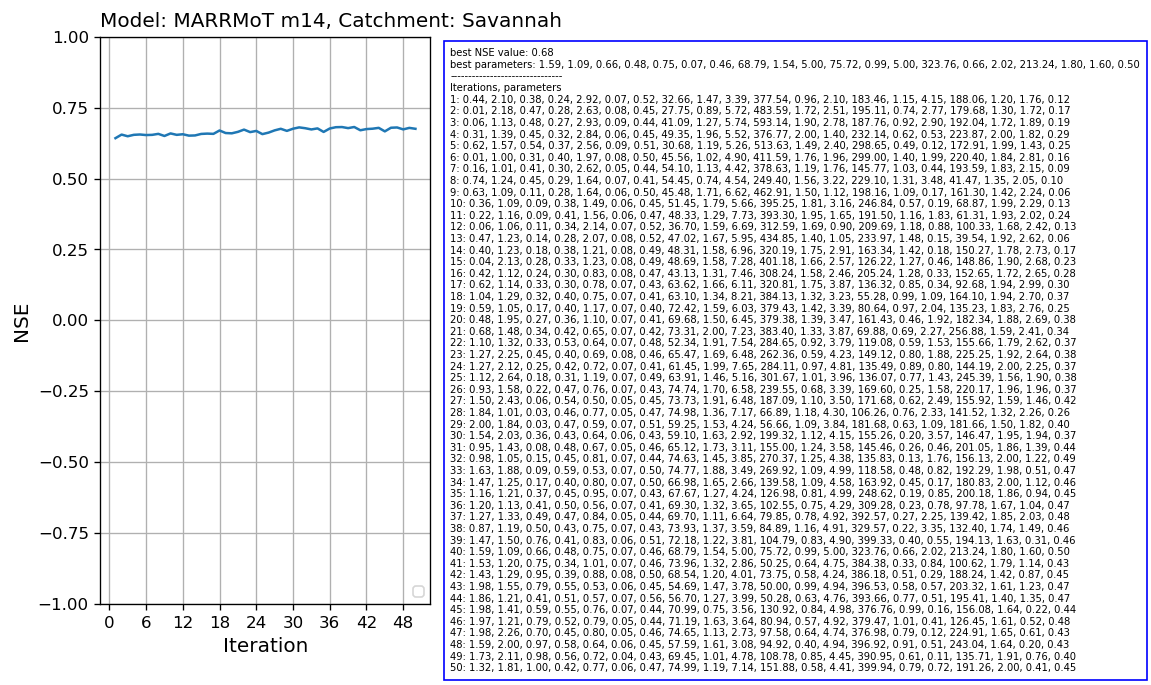

In [4]:
filename = 'cma_calibration_conasauga.yml'
with open(filename) as f:
    calibration_results = yaml.load(f)
fig = plot_parameters(calibration_results[0])
# plt.ylim((-1, 1))
# fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=300)
# calibration_results[1]

In [18]:
calibration_results[1]

ordereddict([('title', 'HBVmountain model optimized parameter based on ED,2st simulation'), ('best_parameter_value', [0.897715287810886, 1.3701122962034518, 0.6191563114801848, 0.12549098615196963, 0.8339848379339249, 0.004020994094361303, 0.7861075373227187, 37.23780400459825, 0.40726999720120194, 1.1270564666408642, 550.6802488419087, 1.9958820201012555, 0.5961696549417487, 15.890352228502747, 1.0766169367771483, 2.0882896113546408, 320.86851005600454, 0.8726256486218766, 2.2896352461603224, 0.31478296021891217]), ('best_NSE_value', 0.43323224045986264), ('other_values', [[[0.9916276545137853, 1.853870485606444, 0.6844412109726433, 0.46094588318309004, 0.9026079446941621, 0.05687136935977118, 0.627951151329599, 21.679160699987474, 0.9147313200574613, 3.9895023309040845, 530.1930158635383, 1.0558061601738629, 0.3762993195513711, 275.254324769681, 1.5404371017256104, 3.4020713094574204, 296.430510876052, 1.1125102374805491, 0.5022230409426437, 0.3684208062844736], -444.35339771440727],

In [20]:
best_par

[0.2868944186486407,
 4.997151478525698,
 0.40595637248026595,
 0.15490154247830815,
 0.7294719327372736,
 0.04722211788448826,
 0.43558142193502375,
 1.017004155476269,
 0.691557287172279,
 1.3122287117050881,
 215.73240591032874,
 0.9259162333996517,
 1.2024878355809363,
 195.3108941980776,
 1.9815989636622433,
 0.41507998904959964,
 123.20711870261468,
 0.6355299877102524,
 2.3298011328560464,
 0.2360573082411621]